In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM , Dense , Dropout
from tensorflow.keras.models import load_model

In [36]:
df = pd.read_csv('Experimental_data_fresh_cell.csv')

In [37]:
features = ['Time', 'Current', 'Voltage']
target = 'Temperature'

In [38]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features + [target]])

In [39]:
x = scaled_data[:, :-1]  
y = scaled_data[:, -1] 

Creaate sequence from the data

In [40]:
def create_sequences(X, y, time_steps):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:(i + time_steps)])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

time_steps = 10

In [41]:
x_seq, y_seq = create_sequences(x, y, time_steps)

In [42]:
x_train, x_test, y_train, y_test = train_test_split(x_seq, y_seq, test_size=0.2, random_state=42)


In [43]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))

model.add(Dense(1))

c:\Users\prana\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [44]:
model.compile(optimizer='adam' , loss = 'mean_squared_error')

In [45]:
history = model.fit(x_train , y_train , epochs = 50 , batch_size = 32 , validation_data=(x_test, y_test))

Epoch 1/50
8958/8958 ━━━━━━━━━━━━━━━━━━━━ 73s 8ms/step - loss: 0.0064 - val_loss: 0.0024
Epoch 2/50
8958/8958 ━━━━━━━━━━━━━━━━━━━━ 72s 8ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 3/50
8958/8958 ━━━━━━━━━━━━━━━━━━━━ 74s 8ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 4/50
8958/8958 ━━━━━━━━━━━━━━━━━━━━ 80s 9ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 5/50
8958/8958 ━━━━━━━━━━━━━━━━━━━━ 67s 7ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 6/50
8958/8958 ━━━━━━━━━━━━━━━━━━━━ 64s 7ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 7/50
8958/8958 ━━━━━━━━━━━━━━━━━━━━ 60s 7ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 8/50
8958/8958 ━━━━━━━━━━━━━━━━━━━━ 60s 7ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 9/50
8958/8958 ━━━━━━━━━━━━━━━━━━━━ 60s 7ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 10/50
8958/8958 ━━━━━━━━━━━━━━━━━━━━ 60s 7ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 11/50
8958/8958 ━━━━━━━━━━━━━━━━━━━━ 61s 7ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 12/50
8958/89

In [46]:
test_loss = model.evaluate(x_test , y_test)
print(f"Test Loss : {test_loss}")

2240/2240 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0017
Test Loss : 0.0016922588692978024


In [47]:
model.save('custom_temperature_forecast.h5')
model.save_weights('custom_temperature_forecast.weights.h5')

In [48]:
y_pred = model.predict(x_test)

2240/2240 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


NORMALIZE THE SCALED DATA

In [49]:
y_test_rescaled = scaler.inverse_transform(np.concatenate((x_test[:, 0], y_test.reshape(-1, 1)), axis=1))[:, -1]
y_pred_rescaled = scaler.inverse_transform(np.concatenate((x_test[:, 0], y_pred.reshape(-1, 1)), axis=1))[:, -1]


TRUE VS PREDICTED TEMPERATURE

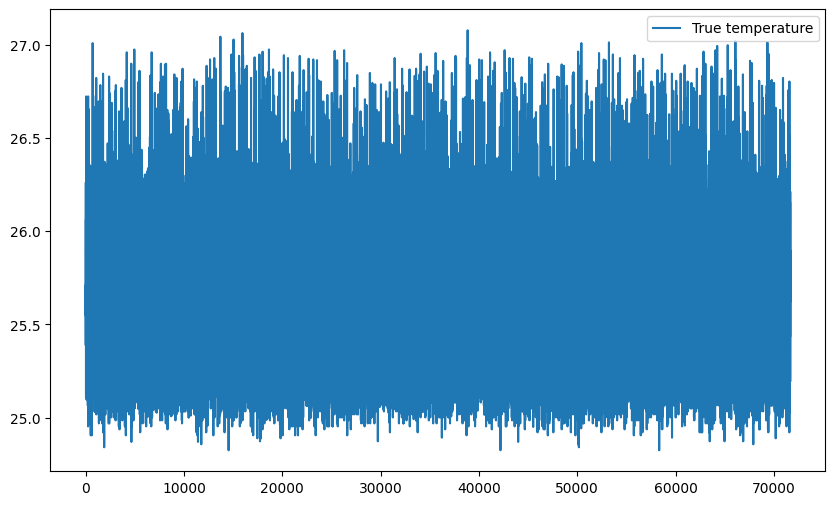

In [50]:
plt.figure(figsize = (10,6))
plt.plot(y_test_rescaled, label = 'True temperature')
plt.plot(y_pred_rescaled = 'Predictted temperature')
plt.legend()
plt.show()

PLOT FOR THE FIRST 300 DATA POINTS

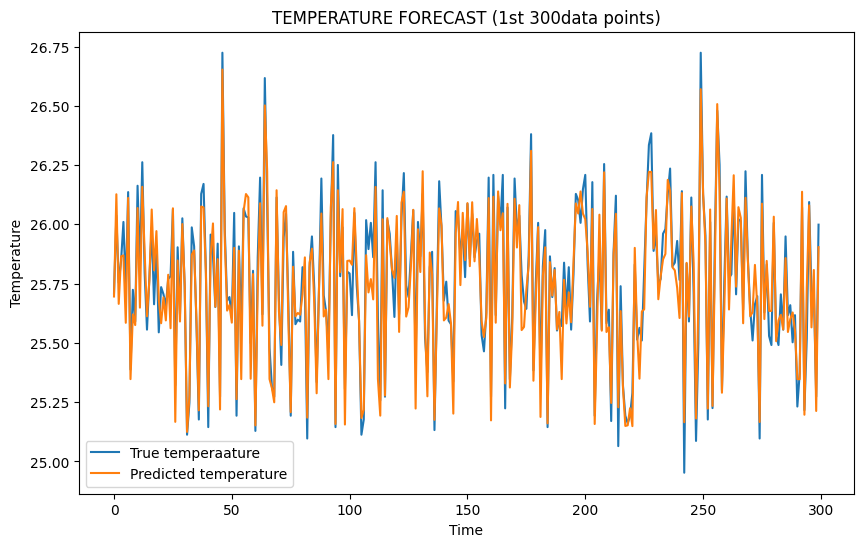

In [51]:
plt.figure(figsize=(10 , 6))
plt.plot(y_test_rescaled[:300], label = "True temperaature")
plt.plot(y_pred_rescaled[:300], label = "Predicted temperature")
plt.legend()
plt.title("TEMPERATURE FORECAST (1st 300data points)")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.show()

SAMPLE INPUT

In [52]:
def predict_custom_input(custom_input):
    # Append a dummy value for the target (e.g., 0) to match the expected number of features
    custom_input_with_dummy = custom_input + [0]  
    custom_input_scaled = scaler.transform([custom_input_with_dummy])
    custom_input_reshaped = custom_input_scaled[:, :-1].reshape(1, 1, len(features))  
    prediction = model.predict(custom_input_reshaped)
    # Inverse transform to get back to original scale (include the dummy input in inverse transformation)
    prediction_rescaled = scaler.inverse_transform(np.concatenate((custom_input_reshaped[:, 0], prediction), axis=1))[:, -1]
    
    return prediction_rescaled


custom_input = [20, 2.158704, 2.999607]  
output = predict_custom_input(custom_input)
print(f"Predicted temperature for custom input: {output}")


c:\Users\prana\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
Predicted temperature for custom input: [25.45975181]


THE FORECAST

In [111]:
initial_sequence = df[df['Time'] <= 20][['Time', 'Current', 'Voltage', 'Temperature']].values
initial_sequence_scaled = scaler.transform(initial_sequence)
current_input = initial_sequence_scaled[:, :-1].reshape(1, initial_sequence.shape[0], -1)

c:\Users\prana\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [112]:
n_future_steps = 5

Reshape to match LSTM input (1, time_steps=1, features=3)

In [113]:
current_input = initial_sequence_scaled[:, :-1].reshape(1, initial_sequence_scaled.shape[0], -1)

print(f"Input shape for LSTM: {current_input.shape}")

Input shape for LSTM: (1, 20, 3)


In [114]:
future_predictions = []

for _ in range(n_future_steps):
    predicted_temp = model.predict(current_input)[0, 0]

    new_row = np.zeros((1, len(features) + 1))  
    new_row[0, :-1] = current_input[:, -1, :]  
    new_row[0, -1] = predicted_temp  

    predicted_temp_rescaled = scaler.inverse_transform(new_row)[0, -1]
    future_predictions.append(predicted_temp_rescaled)

    next_input = np.concatenate(
        (current_input[:, 1:, :], new_row[:, :-1].reshape(1, 1, -1)), axis=1
    )
    current_input = next_input


print("Predicted temperatures for the next 5 time steps:")
for i, temp in enumerate(future_predictions, start=1):
    print(f"Time = {20 + i}: {temp}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Predicted temperatures for the next 20 time steps:
Time = 21: 26.238921171938358
Time = 22: 26.230645072861194
Time = 23: 26.230472186855256
Time = 24: 26.230112205034672
Time = 25: 26.230359065633


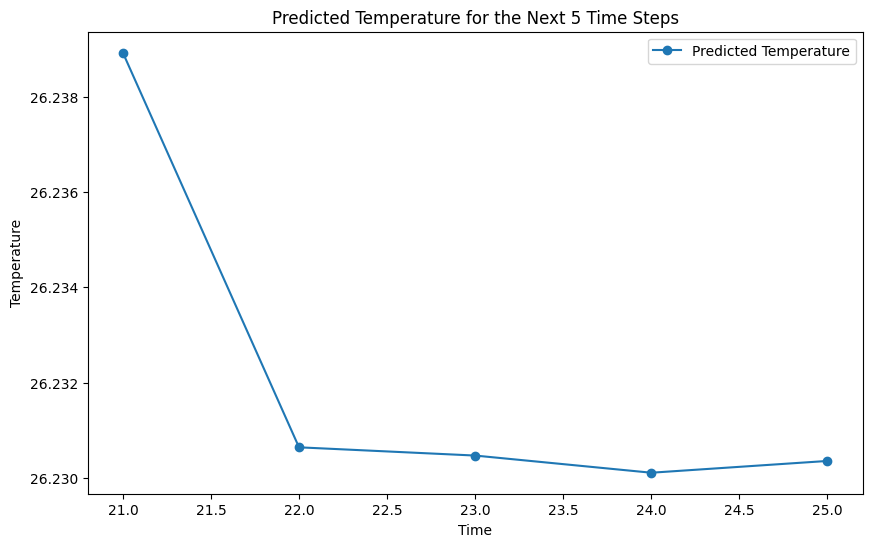

In [116]:
plt.figure(figsize=(10, 6))
plt.plot(range(21, 21 + n_future_steps), future_predictions, marker='o', label='Predicted Temperature')
plt.title("Predicted Temperature for the Next 5 Time Steps")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.legend()
plt.show()